In [ ]:
# step 0 installs
%pip install transformers torch pandas numpy matplotlib networkx seaborn scikit-learn umap-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
# step 0 imports
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import random
import seaborn as sns

c:\Users\yalin\anaconda3\envs\dna_embed\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# step 1: Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("InstaDeepAI/nucleotide-transformer-2.5b-multi-species")
model = AutoModelForMaskedLM.from_pretrained("InstaDeepAI/nucleotide-transformer-2.5b-multi-species")

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.90it/s]


In [4]:
# step 2 function to parse FASTA files
def parse_fasta(file_path):
    with open(file_path) as f:
        seq = []

        for line in f:
            line = line.strip()
            if line.startswith('>'):
                continue
            else:
                seq.append(line)
    return seq

In [5]:
# step 3 parse sequences from data file
strain_1 = parse_fasta('data\GCA_006094915.1\GCA_006094915.1_ASM609491v1_genomic.fna')[0]
strain_2 = parse_fasta('data\GCA_026167765.1\GCA_026167765.1_ASM2616776v1_genomic.fna')[0]
strain_3 = parse_fasta('data\GCA_900607265.1\GCA_900607265.1_BPH2003_genomic.fna')[0]
strain_4 = parse_fasta('data\GCA_900620245.1\GCA_900620245.1_BPH2947_genomic.fna')[0]

In [6]:
# step 4: Define masked embedding function
def get_masked_embedding(sequence):
    tokens = tokenizer(sequence, return_tensors="pt", truncation=True, padding="max_length", max_length=tokenizer.model_max_length)
    input_ids = tokens["input_ids"]
    attention_mask = input_ids != tokenizer.pad_token_id

    with torch.no_grad():
        outputs = model(
            input_ids,
            attention_mask=attention_mask,
            encoder_attention_mask=attention_mask,
            output_hidden_states=True
        )
    embeddings = outputs.hidden_states[-1]
    attention_mask = attention_mask.unsqueeze(-1)
    masked_embeddings = embeddings * attention_mask
    mean_embedding = masked_embeddings.sum(dim=1) / attention_mask.sum(dim=1)
    return mean_embedding.squeeze().numpy()

In [7]:
# step 5: label embeddings for each strain
embedding_for_strain_1 = get_masked_embedding(strain_1)
embedding_for_strain_2 = get_masked_embedding(strain_2)
embedding_for_strain_3 = get_masked_embedding(strain_3)
embedding_for_strain_4 = get_masked_embedding(strain_4) 

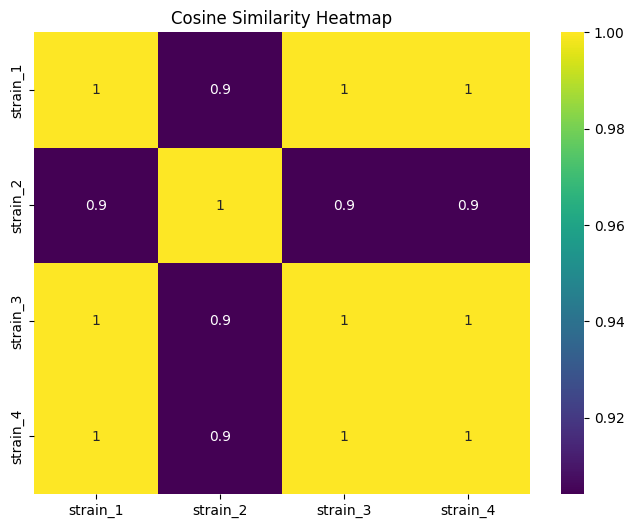

In [8]:
# step 6: Create dataframe with embeddings
headers = ['strain_1', 'strain_2', 'strain_3', 'strain_4']
embeddings = [
    embedding_for_strain_1,
    embedding_for_strain_2,
    embedding_for_strain_3,
    embedding_for_strain_4
]

df_all = pd.DataFrame({
    'Header': headers,
    'embedding': embeddings
})

# step 7: Compute cosine similarity matrix
X = np.stack(df_all['embedding'].values)
similarity_matrix = cosine_similarity(X)

# step 8: Visualize similarity matrix
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix, xticklabels=df_all['Header'], yticklabels=df_all['Header'],
            annot=True, cmap='viridis')
plt.title("Cosine Similarity Heatmap")
plt.show()

# step 9: Clustering using DBSCAN
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=0.1, min_samples=2, metric='cosine').fit(X)
df_all['Cluster'] = clustering.labels_

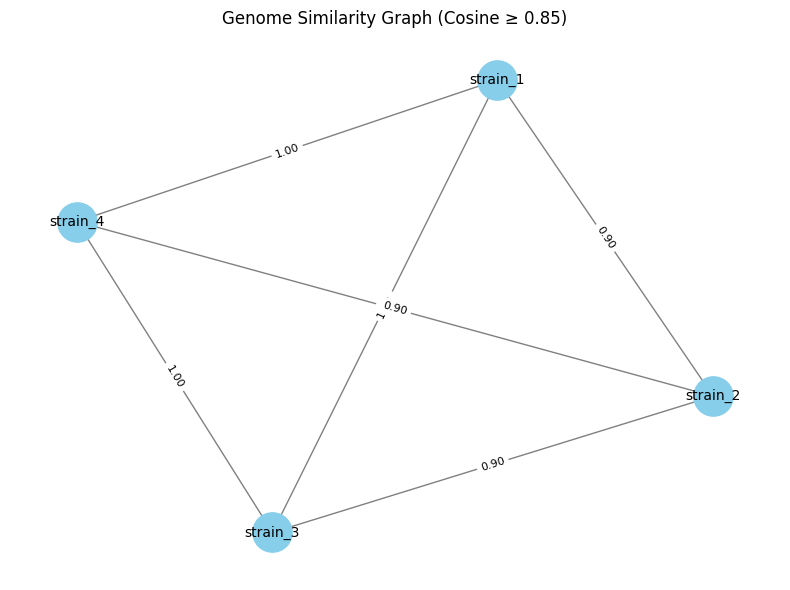

In [9]:
# step 10: Build similarity graph
import networkx as nx

threshold = 0.85  # Adjust as needed
G = nx.Graph()
for i, label_i in enumerate(df_all['Header']):
    G.add_node(label_i)
    for j in range(i+1, len(df_all)):
        if similarity_matrix[i][j] >= threshold:
            G.add_edge(label_i, df_all['Header'][j], weight=similarity_matrix[i][j])

# step 11: Visualise similarity graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=800)
nx.draw_networkx_edges(G, pos, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=10)
edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Genome Similarity Graph (Cosine ≥ 0.85)")
plt.axis('off')
plt.tight_layout()
plt.show()

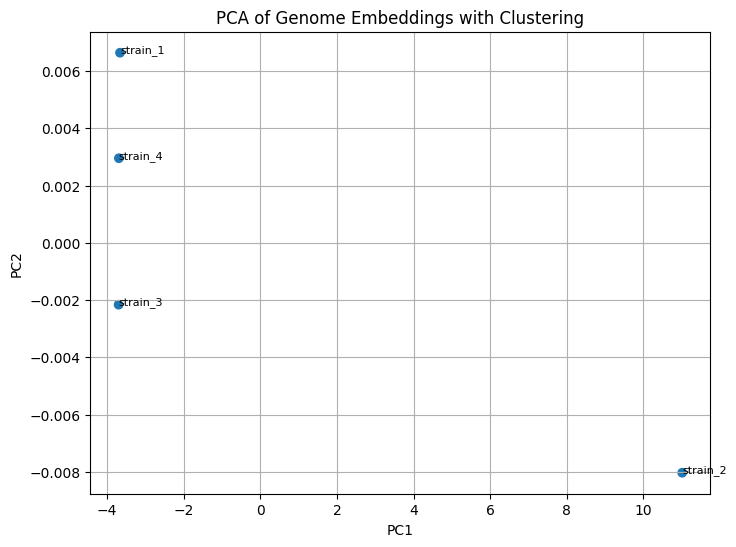

In [10]:
# step 12: PCA visualisation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
jitter = np.random.normal(0, 0.01, X_pca.shape)
X_pca_jittered = X_pca + jitter

unique_clusters = sorted(df_all['Cluster'].unique())
color_map = {cluster: plt.cm.tab10(i % 10) for i, cluster in enumerate(unique_clusters)}
colors = [color_map[c] for c in df_all['Cluster']]

plt.figure(figsize=(8,6))
plt.scatter(X_pca_jittered[:,0], X_pca_jittered[:,1], c=colors)
for i, label in enumerate(df_all['Header']):
    plt.text(X_pca_jittered[i,0], X_pca_jittered[i,1], label, fontsize=8)
plt.title("PCA of Genome Embeddings with Clustering")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

In [13]:
%pip install umap-learn

INFO: pip is looking at multiple versions of umap-learn to determine which version is compatible with other requirements. This could take a while.
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------------------  2.6/2.6 MB 16.7 MB/s eta 0:00:01
   ---------------------------------------- 2.6/2.6 MB 11.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/28.1 MB ? eta -:--:--
   ---- ----------------------------------- 3.4/28.1 MB 16.7 MB/s eta 0:00:02
   --------- ------------------------------ 6.6/28.1 MB 14.9 MB/s eta 0:00:02
   --------------- ------------------------ 10.7/28.1 MB 16.4 MB/s eta 0:00:02
   ------------------- -------------------- 13.9/28.1 MB 15.9 MB/s eta 0:00:01
   ------------------------- -------------- 17.8/28.1 MB 16.1 MB/s eta 0:00:01
   ------------------------------- -------- 22.0/28.1 MB 16.6 MB/s eta 0:00:01
   ------------------------------------ --- 25.7/28.1 MB 16.8 MB/s eta 0:00:01
   ------

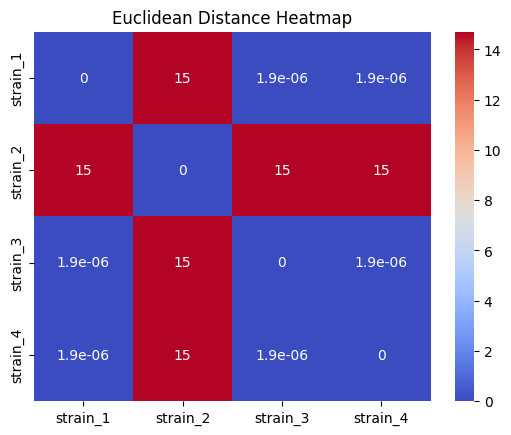

In [11]:
# step 13: euclidean distance matrix and visualisation
from sklearn.metrics import pairwise_distances
distance_matrix = pairwise_distances(X, metric='euclidean')

sns.heatmap(distance_matrix, xticklabels=df_all['Header'], yticklabels=df_all['Header'], annot=True, cmap='coolwarm')
plt.title("Euclidean Distance Heatmap")
plt.show()

c:\Users\yalin\anaconda3\envs\dna_embed\lib\site-packages\umap\umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


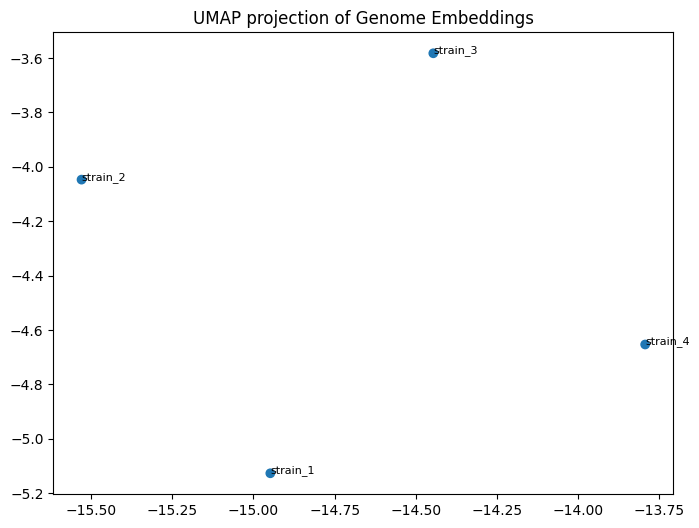

In [14]:
# step 14: UMAP visualisation for non linear relationships between embeddings
from umap import UMAP
umap = UMAP(n_neighbors=5, min_dist=0.3, metric='cosine')
X_umap = umap.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_umap[:,0], X_umap[:,1], c=colors)
for i, label in enumerate(df_all['Header']):
    plt.text(X_umap[i,0], X_umap[i,1], label, fontsize=8)
plt.title("UMAP projection of Genome Embeddings")
plt.show()

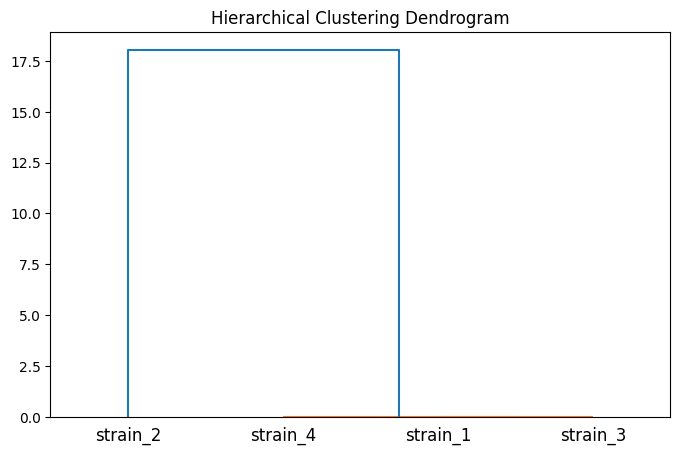

In [ ]:
# step 15: Hierarchical Clustering Dendrogram
from scipy.cluster.hierarchy import linkage, dendrogram

linked = linkage(X, 'ward')
plt.figure(figsize=(8, 5))
dendrogram(linked, labels=df_all['Header'].values)
plt.title("Hierarchical Clustering Dendrogram")
plt.show()